In [1]:
import Pkg; Pkg.activate(".")

  Activating project at `/mnt/chromeos/GoogleDrive/MyDrive/Lab/Optical Instruments/VST/Simulator`


In [2]:
Pkg.instantiate()

In [3]:
using Unitful
using PhysicalConstants.CODATA2018: h, c_0
using PhysicalConstants.CODATA2018	
using UnitfulAstro 
using Distributions
using CairoMakie
using DataFrames
using Interpolations
using CSV

In [4]:
extpath = joinpath("data","Paranal.dat")
extdata = CSV.File(extpath; comment="#",header=["λ", "Ext", "eExt"])
exttbl = DataFrame(extdata)
exttbl.λ .= exttbl.λ.*u"angstrom"
extfnt = linear_interpolation(exttbl.λ, exttbl.Ext, extrapolation_bc = NaN);

In [5]:
gpath = joinpath("data","VST_g_eff.txt")
gdata = CSV.File(gpath; comment="#",header=["λ", "Eff"])
gtbl = DataFrame(gdata)
gtbl.λ .= gtbl.λ.*u"nm"
gtbl.Eff = gtbl.Eff / 100
gfnt = linear_interpolation(gtbl.λ, gtbl.Eff, extrapolation_bc = 0.);

In [6]:
rpath = joinpath("data","VST_r_eff.txt")
rdata = CSV.File(rpath; comment="#",header=["λ", "Eff"])
rtbl = DataFrame(rdata)
rtbl.λ .= rtbl.λ.*u"nm"
rtbl.Eff = rtbl.Eff / 100
rfnt = linear_interpolation(rtbl.λ, rtbl.Eff, extrapolation_bc = 0.);

In [7]:
ppath = joinpath("data","Polaroid.csv")
pdata = CSV.File(ppath; comment="#",header=["λ", "Eff"])
ptbl = DataFrame(pdata)
ptbl.λ .= ptbl.λ.*u"nm"
ptbl.Eff = ptbl.Eff / 100
pfnt = linear_interpolation(ptbl.λ, ptbl.Eff, extrapolation_bc = 0.);

In [8]:
TelescopeAreaPrimario = 2.61u"m"/2
TelescopeAreaSecondario = 0.938u"m"/2
EffArea = π*(TelescopeAreaPrimario^2-TelescopeAreaSecondario^2)
qeffdir = Dict("g" => gfnt, "r" => rfnt);

In [9]:
ncycles = 1
filter = "g"
expt = 600
inpm = 16.
airm = 1.;

In [10]:
inpmag = inpm*UnitfulAstro.AB_mag;

In [11]:
exptime = expt*u"s"
totexptime = exptime*ncycles
perframeoverhead = 39*u"s"
tottelesctime = ncycles*(exptime + 3*perframeoverhead);

In [12]:
SourcePol = 0.0
PosAngle = 45.;

In [13]:
ModSchema = 3
ang1=0.
ang2=60.
ang3=120.;

In [14]:
effTime = (1/ModSchema)*totexptime;

In [15]:
inpflux = uconvert(u"erg/(s*m^2*Hz)",inpmag);

In [16]:
minλ = 3500.0u"angstrom"
maxλ = 9000.0u"angstrom";

In [17]:
function Computeγ(effarea,efftime,inpflux,airm,filter;minλ=3500.0u"angstrom",maxλ=9000.0u"angstrom")
    Numγ = 0.
    EffNumγ = 0.
    for λ in range(start=minλ,stop=maxλ,step=1u"angstrom")
    	bwidth = c_0*u"angstrom"/uconvert(u"m",λ)^2
    	γ = uconvert(u"Hz",bwidth)*effarea*efftime*inpflux/(uconvert(u"erg*s",h)*c_0/uconvert(u"m",λ))
    	airmfct = 10^(-0.4*(extfnt(λ)*airm))
    	Numγ = Numγ + γ
    	EffNumγ = EffNumγ + γ*qeffdir[filter](λ)*airmfct*pfnt(λ)
    end    
    return EffNumγ, Numγ
end

Computeγ (generic function with 1 method)

In [18]:
EffNumγ, Numγ = Computeγ(EffArea,effTime,inpflux,airm,filter);

In [19]:
Q = SourcePol * cosd(2*PosAngle) * EffNumγ
U = SourcePol * sind(2*PosAngle) * EffNumγ;

In [20]:
ModMat = 0.5*[1 cosd(2*ang1) -sind(2*ang1); 1 cosd(2*ang2) -sind(2*ang2); 1 cosd(2*ang3) -sind(2*ang3)];

In [21]:
inpStk = transpose([EffNumγ Q U]);

In [22]:
Is = ModMat * inpStk;

In [23]:
dI0 = rand(Poisson(Is[1]),10000)
dI60 = rand(Poisson(Is[2]),10000)
dI120 = rand(Poisson(Is[3]),10000)
dIs = transpose([dI0 dI60 dI120]);

In [24]:
DemodMat = inv(ModMat);

In [25]:
dStokes = DemodMat * dIs;

In [26]:
sQN = dStokes[2,:] ./ dStokes[1,:] 
sUN = dStokes[3,:] ./ dStokes[1,:];

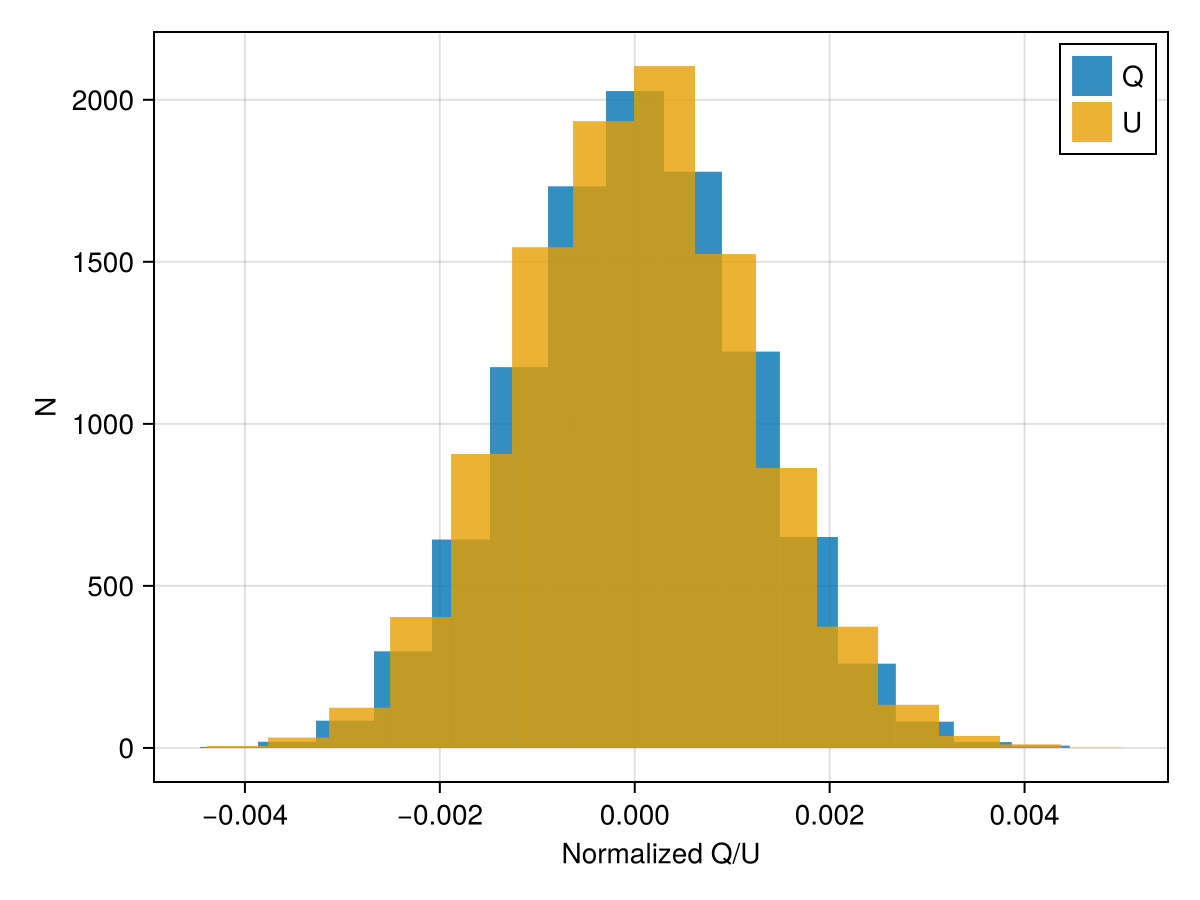

In [27]:
fg1 = Figure()
	
ax1fg1 = Axis(fg1[1, 1],
	xlabel = "Normalized Q/U",
	ylabel = "N"
	)
	
hist!(sQN,label="Q")
hist!(sUN,label="U")
	
axislegend(ax1fg1)
	
fg1

In [28]:
dP = sqrt.(sQN.^2 .+ sUN.^2)
Pres = 100*mean(dP)
PresErr = 100*std(dP)
SN = mean(dP)/std(dP)
Ptrue = Pres*sqrt(1-(PresErr/Pres)^2)
θ = 0.5*atand.(sUN,sQN)
θd = mean(θ)
eθd = std(θ)
sp2 = sqrt((mean(sQN)^2 * std(sQN)^2 + mean(sUN)^2 * std(sUN)^2)/(mean(sQN)^2 + mean(sUN)^2));

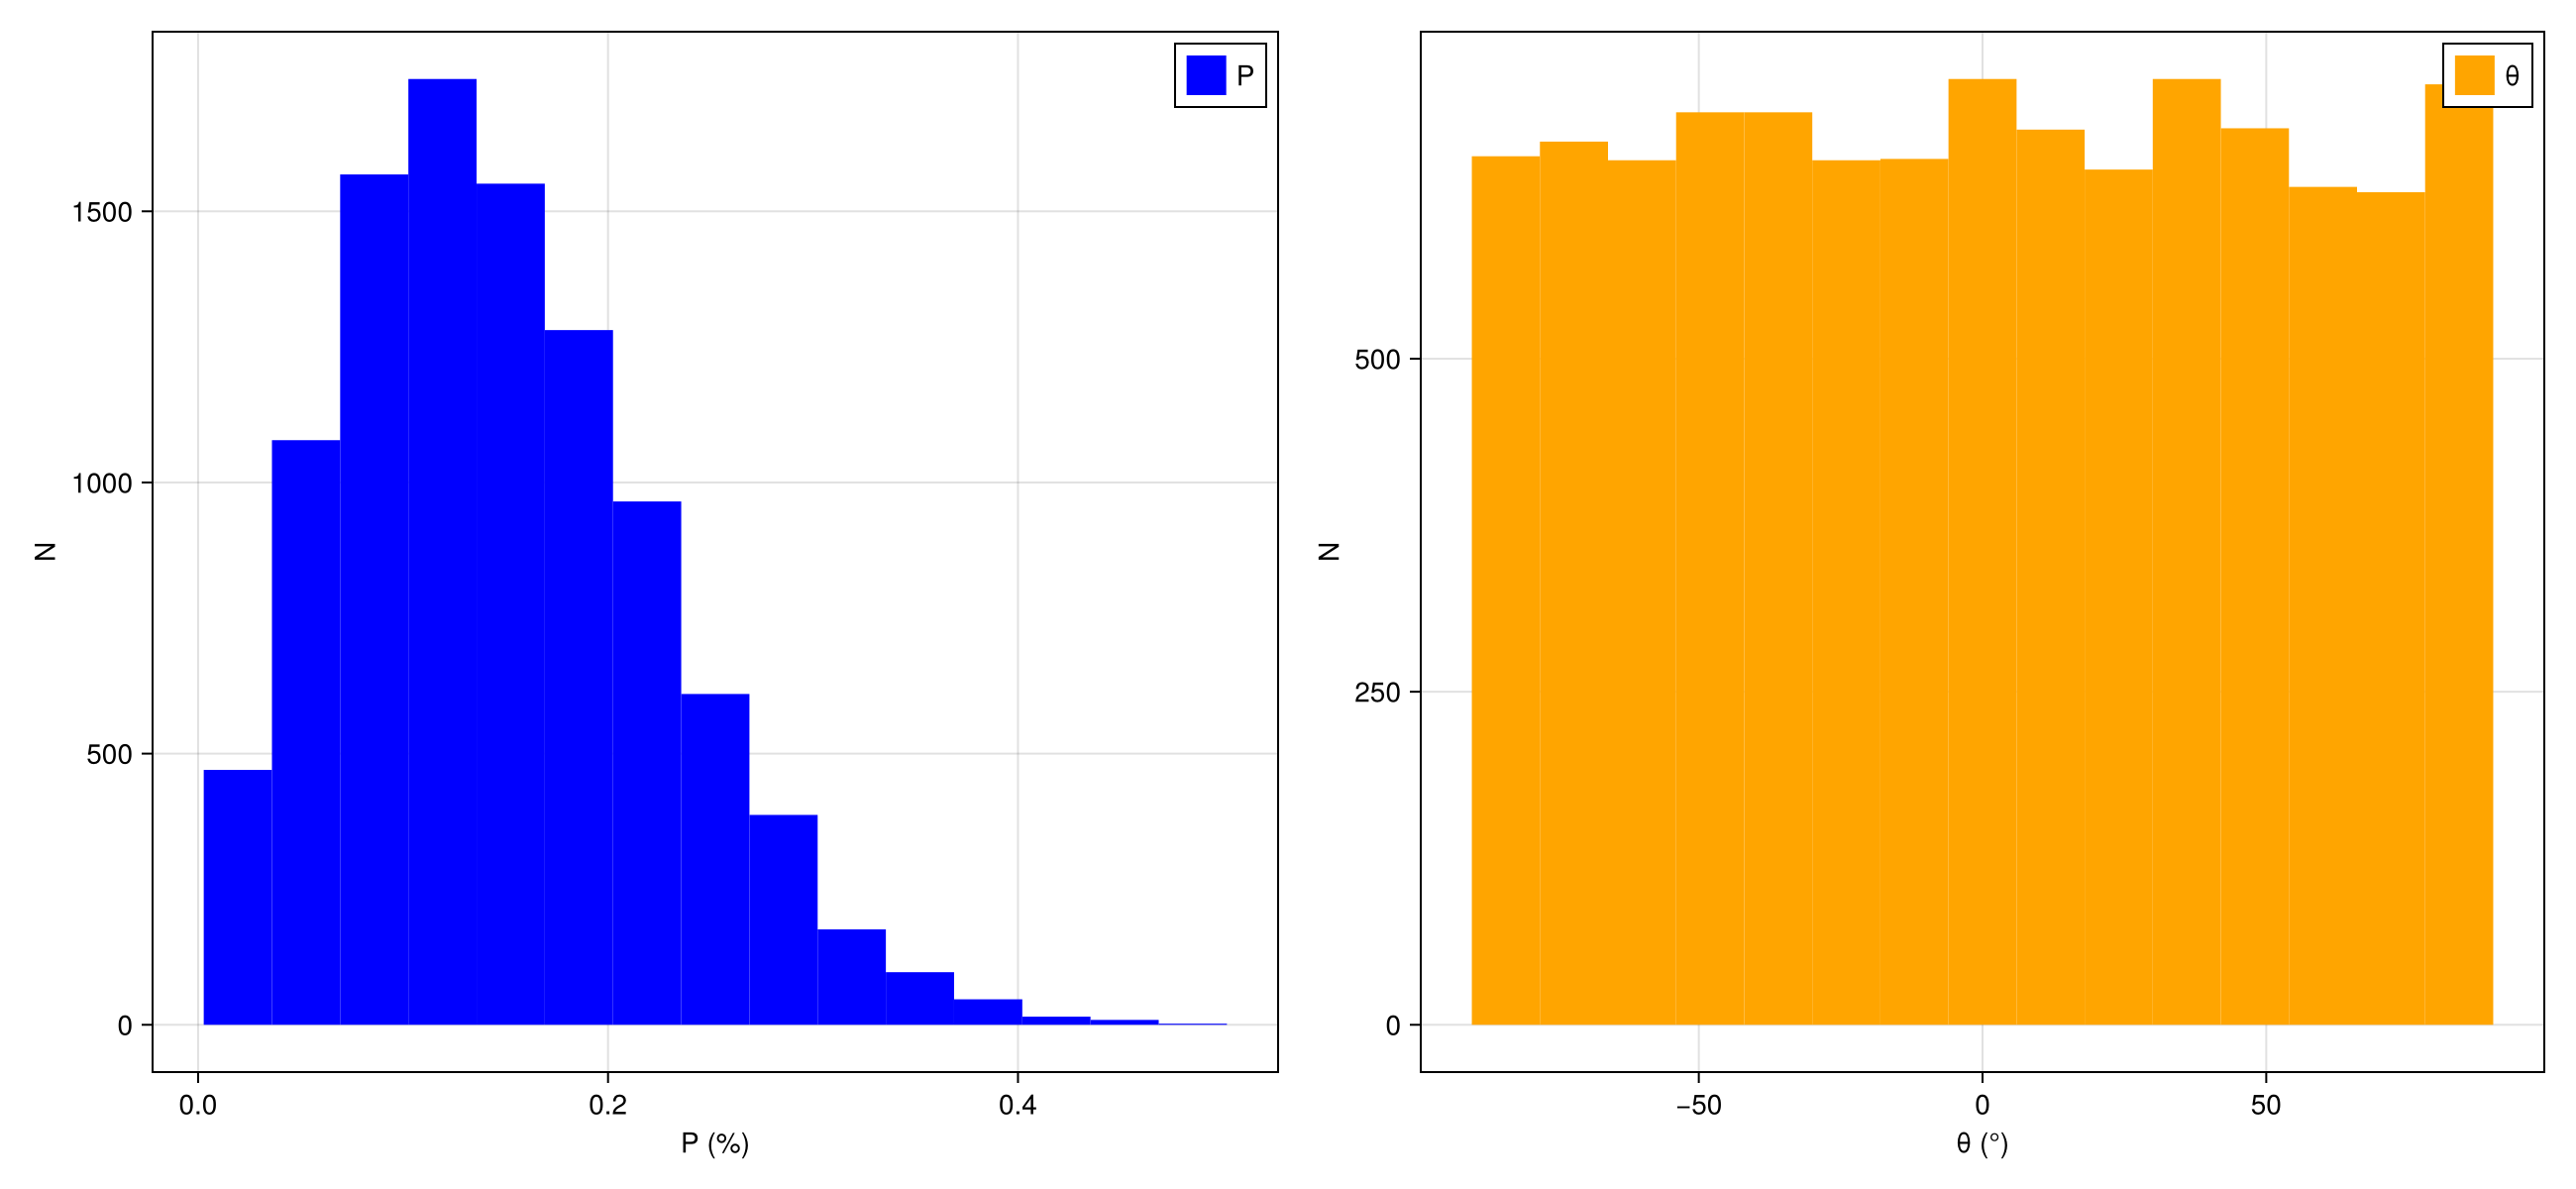

In [29]:
fg2 = Figure(size=(1300,600))
	
ax1fg2 = Axis(fg2[1, 1],
	xlabel = "P (%)",
	ylabel = "N"
	)
	
hist!(100*dP,label="P",color=:blue)
	
axislegend(ax1fg2)

ax2fg2 = Axis(fg2[1, 2],
	xlabel = "θ (°)",
	ylabel = "N"
	)
	
hist!(θ,label="θ",color=:orange)
	
axislegend(ax2fg2)
	
fg2

In [30]:
d = fit(Rayleigh,sqrt.((sQN.-mean(sQN)).^2 .+ (sUN.-mean(sUN)).^2))

Rayleigh{Float64}(σ=0.0011778591486223536)

In [31]:
PresErr,sp2,std(sQN),std(sUN)

(0.07675737272027018, 0.001181317810408488, 0.001173182887979044, 0.001182634245032893)

In [43]:
params(d)[1]

0.0011778591486223536